In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [2]:
spx_path = "data/SPX_database_2010.xlsx"
df_tri = pd.read_excel(spx_path, sheet_name="total_ret").set_index("Dates")
df_tri
df_sofr = pd.read_excel("./data/sofr.xlsx")
df_sofr.rename(columns={"Data": "Dates"}, inplace=True)
df_sofr["Dates"] = pd.to_datetime(df_sofr["Dates"]) 
df_sofr = df_sofr.set_index("Dates").sort_index()
df_sofr["Taxa_diaria"] = ((1 + df_sofr["Price"]) ** (1/252)) -1
df_sofr

,Price,Taxa_diaria
Dates,,
2014-01-02,0.0005,0.000002
2014-01-03,0.0005,0.000002
2014-01-06,0.0005,0.000002
2014-01-07,0.0004,0.000002
2014-01-08,0.0004,0.000002
...,...,...
2025-07-28,0.0436,0.000169
2025-07-29,0.0436,0.000169
2025-07-30,0.0432,0.000168


In [3]:
df_tri = df_tri[(df_tri.index.year >= 2014) & (df_tri.index.year <= 2023)]
df_sofr = df_sofr[(df_sofr.index.year >= 2014) & (df_sofr.index.year <= 2023)]
df_original = df_tri

In [4]:
def _choose_30(tri_df, random_state=42):
	tick_tri = [c for c in tri_df.columns if c != "Dates"]
	eligible = sorted(set(tick_tri))

	rng = np.random.default_rng(random_state)
	chosen = rng.choice(eligible, size=30, replace=False)
	return [str(x) for x in chosen]


tri_30 = _choose_30(df_tri)
tri_30[:5]

['MSI UN Equity.1',
 'K UN Equity.1',
 'GRMN UN Equity',
 'SW UN Equity.1',
 'AVGO UW Equity.1']

In [5]:
df_tri = df_tri[tri_30]
df_tri

,MSI UN Equity.1,K UN Equity.1,GRMN UN Equity,SW UN Equity.1,AVGO UW Equity.1,AXON UW Equity,CL UN Equity,SPG UN Equity,REG UW Equity.1,NVR UN Equity,...,HOLX UW Equity,LDOS UN Equity,HON UW Equity,IT UN Equity,POOL UW Equity,URI UN Equity,OXY UN Equity.1,MSCI UN Equity,AVB UN Equity,PNW UN Equity.1
Dates,,,,,,,,,,,,,,,,,,,,,
2014-01-01,79.1479,86.5198,22.1200,NaN,5.583,15.88,86.3449,263.554,NaN,1026.01,...,22.35,53.2463,NaN,71.05,69.1511,77.9500,129.3387,43.7200,215.727,103.0491
2014-01-02,77.7760,86.1514,22.1200,NaN,5.558,15.38,85.1399,263.433,NaN,1017.10,...,21.94,52.9714,NaN,69.80,68.2234,76.4900,127.6387,43.1500,215.745,101.3550
2014-01-03,77.6236,85.8256,22.1200,NaN,5.579,15.67,84.9810,266.654,NaN,1019.35,...,22.19,53.7617,NaN,69.74,68.1996,77.1600,127.1898,43.1700,218.518,101.3939
2014-01-06,77.2953,85.3580,22.1200,NaN,5.541,15.64,84.9281,268.456,NaN,1025.63,...,21.66,53.1432,NaN,69.05,67.2838,77.3700,127.5707,43.1000,221.766,101.3160
2014-01-07,77.6119,86.1372,22.1200,NaN,5.593,15.91,85.0075,268.265,NaN,1013.88,...,21.92,54.4145,NaN,69.05,67.6287,77.7800,129.9507,43.5400,220.817,102.0949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,433.9753,114.5742,528.7137,NaN,153.599,259.03,131.1663,420.948,82.5988,6980.17,...,71.04,206.8523,217.1875,446.49,528.1599,578.5570,123.2807,622.0938,469.475,203.8847
2023-12-26,434.1854,115.6678,532.2230,NaN,154.956,258.11,132.0686,424.972,83.3428,7008.20,...,71.11,207.3712,219.7223,446.47,534.5334,588.6575,124.5579,620.9764,471.831,204.5153
2023-12-27,434.7737,116.0253,531.2321,NaN,154.173,259.08,132.1688,425.001,83.1692,7024.82,...,70.94,207.2175,220.7573,446.63,538.3335,587.0248,123.7470,625.7891,474.989,202.9388


Top ['AVGO UW Equity.1', 'HAL UN Equity', 'URI UN Equity', 'AVB UN Equity', 'FFIV UW Equity', 'SPG UN Equity', 'JBL UN Equity.1', 'HOLX UW Equity', 'CNP UN Equity', 'RF UN Equity', 'K UN Equity.1', 'PNW UN Equity.1', 'CL UN Equity', 'NVR UN Equity', 'OXY UN Equity.1', 'MSCI UN Equity', 'BLK UN Equity.1', 'GRMN UN Equity'] Last ['AXON UW Equity', 'LDOS UN Equity', 'STLD UW Equity.1', 'POOL UW Equity', 'MSI UN Equity.1', 'IT UN Equity', 'GRMN UN Equity', 'BLK UN Equity.1', 'MSCI UN Equity', 'OXY UN Equity.1', 'NVR UN Equity', 'CL UN Equity', 'PNW UN Equity.1', 'K UN Equity.1', 'RF UN Equity', 'CNP UN Equity', 'HOLX UW Equity', 'JBL UN Equity.1']
Top ['AVGO UW Equity.1', 'AXON UW Equity', 'AVB UN Equity', 'SPG UN Equity', 'PNW UN Equity.1', 'HOLX UW Equity', 'MSCI UN Equity', 'FFIV UW Equity', 'NVR UN Equity', 'JBL UN Equity.1', 'IT UN Equity', 'K UN Equity.1', 'URI UN Equity', 'BLK UN Equity.1', 'POOL UW Equity', 'CNP UN Equity', 'CL UN Equity', 'GRMN UN Equity'] Last ['HAL UN Equity', '

C:\Users\caiol\AppData\Local\Temp\ipykernel_4588\3178096864.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()
C:\Users\caiol\AppData\Local\Temp\ipykernel_4588\3178096864.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()
C:\Users\caiol\AppData\Local\Temp\ipykernel_4588\3178096864.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets

Dates                 
2014-08-15  Periodo 1     0.998109
2014-08-18  Periodo 1     0.995843
2014-08-19  Periodo 1     0.990582
2014-08-20  Periodo 1     0.995840
2014-08-21  Periodo 1     0.992906
                            ...   
2023-12-14  Periodo 18    1.237008
2023-12-15  Periodo 18    1.243481
2023-12-18  Periodo 18    1.243366
2023-12-19  Periodo 18    1.246649
2023-12-20  Periodo 18    1.243574
Length: 1062, dtype: float64

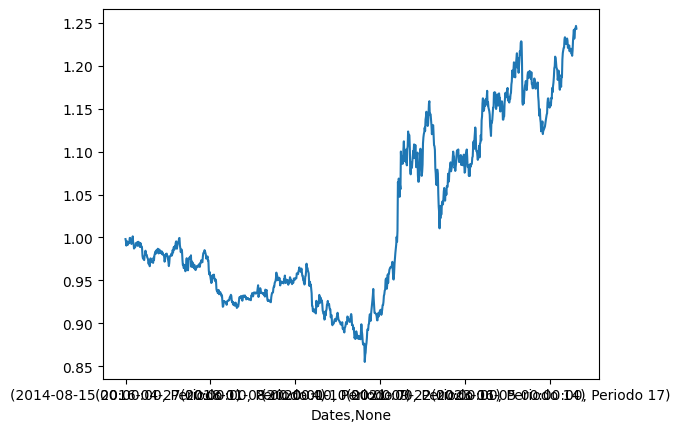

In [81]:
import numpy as np
import pandas as pd

def momentum_simple_daily(prices) -> pd.DataFrame:
    rets = prices.pct_change()
    log1p = np.log1p(rets)
    cum_log = log1p.cumsum()
    score = np.expm1(cum_log)
    score 
    return score.iloc[-1]

def rebalanciar(df):
    ranking = momentum_simple_daily(df)
    num_nans = ranking.isna().sum()

    top = ranking.nlargest(15 + (num_nans // 2)).index.tolist()
    last = ranking.nsmallest(15 + (num_nans // 2)).index.tolist()
    print("Top", top, "Last", last)
    return top, last

def portifolio(df, janela, skip, holding):
    janelas = df.shape[0] // janela
    retornos = []

    for i in range(int(janelas)):
        janela_start = 0 if i == 0 else max(0, (i - 1) * janela)
        corte = min((i + 1) * janela, len(df))

        top, last = rebalanciar(df.iloc[janela_start:corte])



        start = corte + skip
        end   = min(start + holding, len(df))
        if start >= end:
            break

        retorno_top  = df.iloc[start:end][top].pct_change().iloc[1:]  
        retorno_last = df.iloc[start:end][last].pct_change().iloc[1:] * -1
        r = (retorno_top.mean(axis=1) + retorno_last.mean(axis=1)).to_frame(name=f"Periodo {i+1}")
        retornos.append(r)

    return retornos

teste = portifolio(df_tri, janela=140, skip=21, holding=60)
teste = pd.concat(teste) 
teste = teste.stack().sort_index(level=0)
teste = (teste + 1).cumprod()
teste.plot()
teste


In [79]:
serie_unica = teste.stack().sort_index(level=0)

# retorno acumulado total
ret_acum_total = (1 + serie_unica/100).prod() - 1

print("Retorno acumulado total:", f"{ret_acum_total:.2%}")


Retorno acumulado total: 3962271.95%


In [75]:
serie_unica

Dates                 
2014-08-15  Periodo 1     0.998109
2014-08-18  Periodo 1     0.995843
2014-08-19  Periodo 1     0.990582
2014-08-20  Periodo 1     0.995840
2014-08-21  Periodo 1     0.992906
                            ...   
2023-12-14  Periodo 18    1.063898
2023-12-15  Periodo 18    1.069464
2023-12-18  Periodo 18    1.069366
2023-12-19  Periodo 18    1.072189
2023-12-20  Periodo 18    1.069544
Length: 1062, dtype: float64

Cross-sectional Momentum

 Rank assets by measures of past performance: lookback period

 
 Buy winners and short losers
 
 Hold assets for a pre-defined periods: holding period
 
 Symmetric: buy and sell same number of assets or at least same 
notional

Time-series Momentum

 Analyze performance of each asset individually with same metric: 
lookback period

 Buy winners and short losers

 Hold assets for a pre-defined periods: holding period

 Assymmetric: you may even buy all assets or sell all assets

